***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Experiment 4_2_1</span> 

# Helmholtz Machine on Self-organizing System without Root

In this experiment, the self-organizing system doesn't root on any fixed dataset, instead it uses its pure sampled instances as dataset on each iteration. The question is, given the dataset size, can we find the best subset that the model could fit? This problem is not trivial, as even if we remove the restriction of fixed set, its still impossible for the model to traverse the whole space and construct the optimal subsapce in one training process. Here we perform an extension on datasize first then concentrate it on its original size. By performing it back and forth, we distrurb the parameters from its local optima to a better optimal status globally. 

*Created:* December 27, 2023

*Updated:* December 27, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

In [2]:
structure = [[12,10,8,7,5,4,3,1]]
n_dz = np.array(structure)
n_dz

array([[12, 10,  8,  7,  5,  4,  3,  1]])

In [3]:
value_set = [1,0]
activation_type = "tanh"
bias = [False,False,False] # [instantiation bias, MLP bias,data bias]

In [6]:
n = n_dz[0,0]

In [7]:
entire_set = ut.all_comb(n, value_set)

Self-organizing System:

In [8]:
Phi, Theta = ut.parameter_initialization("zero",n_dz)  # "zero" or "random"

In [81]:
lr = 0.01
epoch = 50

In [87]:
update_rate = 100 # after how many epochs we update evidence
d_size = 600 # how many new samples to add at each update

In [88]:
dataset = ut.generate(d_size,n_dz,value_set,Theta,activation_type,bias)

In [89]:
# rate of dataset size expansion
diff_criteria = 5
n_add = 10
prev_n_sampled = 0
prev_perct = 0
# rev = 0
hold = 3

In [90]:
for e in range(epoch):
    new_sampled = np.zeros((n,d_size*update_rate))
#     Loss_Q_total = np.zeros(n_layer)
#     Loss_P_total = np.zeros(n_layer)

    for r in range (update_rate):
        index = np.random.permutation(d_size)
        for i in range(d_size):
            d0 = dataset[:,index[i]:index[i]+1]
            Alpha_Q = ut.wake_sample(n_dz,d0,value_set,Phi,activation_type,bias)
            Theta,Loss_P = ut.sleep_update_delta(Theta,Alpha_Q,lr,n_dz,value_set,activation_type,bias)
            Alpha_P = ut.sleep_sample(n_dz,value_set,Theta,activation_type,bias)
            Phi,Loss_Q = ut.wake_update_delta(Phi,Alpha_P,lr,n_dz,value_set,activation_type,bias)

            new_sampled[:,i+d_size*r:i+d_size*r+1] = Alpha_P['z0']

    values,counts = np.unique(new_sampled,axis=1,return_counts = True)
    n_sampled = counts.size
    new_samples = values[:,np.argsort(counts)[-d_size:]]
    perct = counts[np.argsort(counts)[-d_size:]].sum()/counts.sum()
    n_diff = np.unique(np.append(dataset,new_samples,axis=1),axis=1).shape[1] - d_size
    
    if n_diff < diff_criteria:
        rev += 1
        if rev > hold:
            if prev_n_sampled < n_sampled or prev_perct > perct:
                d_size += n_add
                new_samples = values[:,np.argsort(counts)[-d_size:]]
                rev = 0
    else:
        rev = 0
    prev_n_sampled = n_sampled
    prev_perct = perct
    
    if n_sampled < d_size:
        print('Complete')
        break
    dataset = new_samples  # renew dataset
    print('New sampled: ' + str(n_sampled),'dataset size: ' + str(d_size),'sample difference: ' + str(n_diff), 'percentage: ' + str(perct))

New sampled: 818 dataset size: 600 sample difference: 3 percentage: 0.9959166666666667
New sampled: 1138 dataset size: 600 sample difference: 16 percentage: 0.9856333333333334
New sampled: 1123 dataset size: 600 sample difference: 18 percentage: 0.9797
New sampled: 1076 dataset size: 600 sample difference: 9 percentage: 0.9768833333333333
New sampled: 1001 dataset size: 600 sample difference: 3 percentage: 0.97795
New sampled: 960 dataset size: 600 sample difference: 3 percentage: 0.9803166666666666
New sampled: 924 dataset size: 600 sample difference: 2 percentage: 0.9805166666666667
New sampled: 944 dataset size: 610 sample difference: 3 percentage: 0.9800333333333333
New sampled: 948 dataset size: 610 sample difference: 1 percentage: 0.9846229508196721
New sampled: 941 dataset size: 610 sample difference: 2 percentage: 0.984655737704918
New sampled: 936 dataset size: 610 sample difference: 2 percentage: 0.984983606557377
New sampled: 893 dataset size: 610 sample difference: 2 percen

In [57]:
prev_perct

0.97304

In [45]:
n_sample = 10000
generation = ut.generate(n_sample,n_dz,value_set,Theta,activation_type,bias)
reordered_set = ut.reorder_all_comb(entire_set,dataset)
distribution,data_dist,statistics, MSE, ABS_Error = ut.metrics(generation,reordered_set,dataset)
values_t, counts_t = np.unique(distribution, return_counts=True)
values_d, counts_d  = np.unique(data_dist, return_counts=True)
counts_t = counts_t/n_sample*d_size

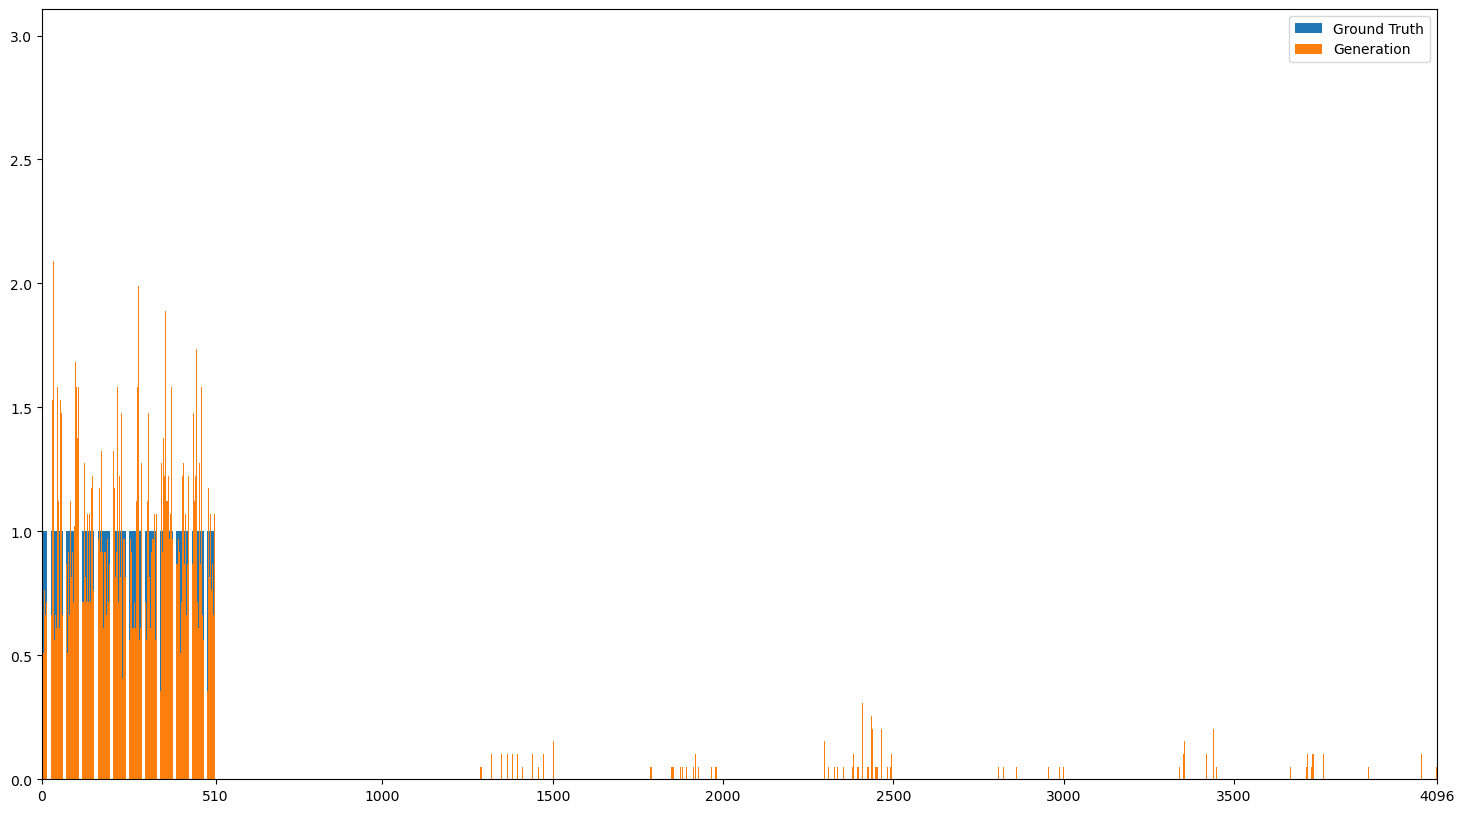

In [46]:
# visualization
x_lim = reordered_set.shape[1]
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
xtick[np.argmin(np.abs(xtick - values_d.size))] = values_d.size
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values_d,counts_d,label = "Ground Truth")
ax.bar(values_t,counts_t,label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
plt.legend()

In [47]:
statistics

{'percent': 0.964,
 'FN': array([], dtype=int32),
 'n_fn': 0,
 'FP': array([[ 562,  964, 1207, 1288, 1289, 1290, 1291, 1306, 1307, 1320, 1321,
         1337, 1349, 1350, 1351, 1352, 1366, 1367, 1381, 1382, 1395, 1397,
         1398, 1409, 1411, 1412, 1427, 1428, 1440, 1441, 1442, 1443, 1457,
         1458, 1459, 1473, 1487, 1489, 1502, 1503, 1516, 1518, 1519, 1785,
         1786, 1787, 1788, 1790, 1800, 1816, 1823, 1836, 1838, 1849, 1851,
         1852, 1854, 1855, 1861, 1875, 1880, 1881, 1885, 1893, 1897, 1898,
         1905, 1912, 1913, 1919, 1928, 1929, 1948, 1962, 1965, 1966, 1978,
         1979, 1981, 2009, 2014, 2199, 2296, 2297, 2298, 2299, 2310, 2311,
         2324, 2325, 2326, 2327, 2336, 2353, 2354, 2355, 2364, 2366, 2367,
         2380, 2381, 2382, 2383, 2395, 2398, 2408, 2409, 2410, 2411, 2420,
         2422, 2423, 2424, 2426, 2427, 2436, 2437, 2438, 2439, 2448, 2451,
         2454, 2464, 2465, 2466, 2467, 2481, 2482, 2483, 2492, 2493, 2494,
         2495, 2506, 2507, 2776,

In [48]:
MSE

0.1157252

In [419]:
# parameters = {'Phi': Phi, 'Theta': Theta}
# np.save('self_org_dataset_97.npy',dataset)
# np.save('self_org_parameters_97.npy',parameters)